# VGG-16 network

### Import needed libraries

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
# Simple CNN model for CIFAR-10
from keras.datasets import cifar10
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, concatenate, BatchNormalization
from keras.constraints import maxnorm
from keras.optimizers import SGD, RMSprop
from keras.layers.convolutional import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import np_utils
from keras.models import load_model
from keras.applications import resnet50
import keras.backend.tensorflow_backend as K2
from keras import backend as K
K.common.image_dim_ordering()

import tensorflow as tf
from pathlib import Path
import matplotlib.pyplot as plt

### Create variables to save net weights and loss and accuracy images

In [0]:
weights_path = './weights_2.h5'
loss_img_name = 'loss_'+ str(num_img_train) +'.png'
accuracy_img_name = 'accuracy_'+ str(num_img_train) +'.png'

### File with the parameters of the network

In [0]:
weights_file = Path(weights_path)

### Fix random seed for reproducibility

In [0]:
seed = 7
np.random.seed(seed)

### Don't be greedy on GPU RAM

In [0]:
config = tf.ConfigProto()
# ask for GPU memory gracefully
config.gpu_options.allow_growth = True

sess = tf.Session(config=config)

K2.set_session(sess)

### Load data and prepare it for the training process

In [70]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

# normalize inputs from 0-255 to 0.0-1.0
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train = X_train / 255.0
X_test = X_test / 255.0

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]

print("num_training_samples: ", X_train.shape)

num_training_samples:  (50000, 32, 32, 3)


### Create network model

In [71]:
#  dropout rate for FC layers
dropout = 0.4

# CNN architecture

input_image = Input(shape=(32,32,3))
# Block 1
x = Conv2D(64, (3, 3),
                  padding='same', 
                  activation='relu', 
                  name="block1_conv1")(input_image)
x = Conv2D(64, (3, 3),
                  padding='same', 
                  activation='relu', 
                  name="block1_conv2")(x)
x = MaxPooling2D((2, 2), name='block1_pool')(x)
x = Dropout(dropout)(x)

# Block 2 
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = MaxPooling2D((2, 2), name='block2_pool')(x)
x = Dropout(dropout)(x)

# Block 3
x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = Conv2D(256, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = MaxPooling2D((2, 2), name='block3_pool')(x)
x = Dropout(dropout)(x)

# Block 4
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv1')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv2')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block4_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool')(x)
x = Dropout(dropout)(x)

# Block 5
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv1')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv2')(x)
x = Conv2D(512, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block5_conv3')(x)
x = MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool')(x)
x = Dropout(dropout)(x)

x = Flatten(name='flatten')(x)
x = Dense(512, activation='relu', name='fc1')(x)
x = Dropout(0.5)(x)
x = Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=input_image, output=x, name='vgg16')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:79: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., name="vgg16", outputs=Tensor("pr...)`


### Initialize training parameters

In [72]:
epochs = 70
lrate = 0.001
decay = 0
opt = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
#opt = RMSprop(lr=0.0001, decay=3e-6)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_12 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
dropout_52 (Dropout)         (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584

### Fit the model

In [73]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/70
50000/50000 [==============================] - 36s 728us/step - loss: 2.3022 - acc: 0.1033 - val_loss: 2.3024 - val_acc: 0.1170
Epoch 2/70
50000/50000 [==============================] - 34s 680us/step - loss: 2.2711 - acc: 0.1408 - val_loss: 2.2133 - val_acc: 0.1685
Epoch 3/70
50000/50000 [==============================] - 34s 680us/step - loss: 2.1039 - acc: 0.1915 - val_loss: 2.1011 - val_acc: 0.1753
Epoch 4/70
50000/50000 [==============================] - 34s 685us/step - loss: 1.9418 - acc: 0.2035 - val_loss: 2.0134 - val_acc: 0.2008
Epoch 5/70
50000/50000 [==============================] - 34s 686us/step - loss: 1.8806 - acc: 0.2312 - val_loss: 1.9824 - val_acc: 0.2202
Epoch 6/70
50000/50000 [==============================] - 34s 689us/step - loss: 1.8198 - acc: 0.2694 - val_loss: 1.8136 - val_acc: 0.2825
Epoch 7/70
50000/50000 [==============================] - 34s 685us/step - loss: 1.7100 - acc: 0.3239 - val_loss: 1.

### Final evaluation of the model

In [74]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.90%


### Plot history for accuracy for training and testing process

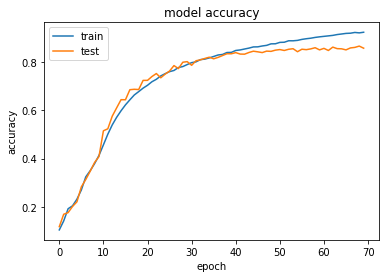

In [75]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

### Plot history for loss for training and testing process

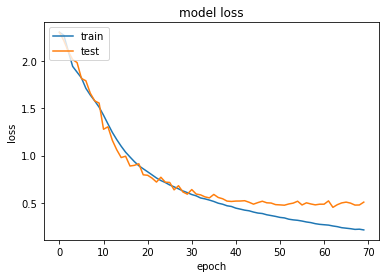

In [76]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()

### Create a smaller model

In [77]:
# CNN architecture

input_image = Input(shape=(32,32,3))
# Block 1
x = Conv2D(32, (3, 3),
                  padding='same', 
                  activation='relu', 
                  name="block1_conv1")(input_image)
x = BatchNormalization()(x)
x = Conv2D(32, (3, 3),
                  padding='same', 
                  activation='relu', 
                  name="block1_conv2")(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name='block1_pool')(x)
x = Dropout(0.2)(x)

# Block 2 
x = Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(64, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block2_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name='block2_pool')(x)
x=Dropout(0.3)(x)

# Block 3
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv1')(x)
x = BatchNormalization()(x)
x = Conv2D(128, (3, 3),
                  activation='relu',
                  padding='same',
                  name='block3_conv2')(x)
x = BatchNormalization()(x)
x = MaxPooling2D((2, 2), name='block3_pool')(x)
x=Dropout(0.3)(x)

x = Flatten()(x)
x=Dense(128, activation='relu', name='fc1')(x)
x=Dropout(0.4)(x)

out= Dense(num_classes, activation='softmax', name='predictions')(x)

model = Model(inputs=input_image, output=out);

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:51: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("pr...)`


### Initialize training parameters

In [78]:
epochs = 60
lrate = 0.001
decay = 0
opt = SGD(lr=lrate, momentum=0.9, decay=decay, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
print(model.summary())

Model: "model_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        (None, 32, 32, 3)         0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 32)        896       
_________________________________________________________________
batch_normalization_13 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 32)        9248      
_________________________________________________________________
batch_normalization_14 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 32)        0         
_________________________________________________________________
dropout_58 (Dropout)         (None, 16, 16, 32)        0   

### Fit the model

In [79]:
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=32)

Train on 50000 samples, validate on 10000 samples
Epoch 1/60
50000/50000 [==============================] - 18s 360us/step - loss: 1.7785 - acc: 0.3497 - val_loss: 1.4086 - val_acc: 0.4849
Epoch 2/60
50000/50000 [==============================] - 16s 313us/step - loss: 1.4342 - acc: 0.4805 - val_loss: 1.1958 - val_acc: 0.5658
Epoch 3/60
50000/50000 [==============================] - 16s 319us/step - loss: 1.2586 - acc: 0.5448 - val_loss: 1.2233 - val_acc: 0.5716
Epoch 4/60
50000/50000 [==============================] - 16s 313us/step - loss: 1.1359 - acc: 0.5987 - val_loss: 1.0548 - val_acc: 0.6242
Epoch 5/60
50000/50000 [==============================] - 16s 314us/step - loss: 1.0533 - acc: 0.6277 - val_loss: 1.0436 - val_acc: 0.6352
Epoch 6/60
50000/50000 [==============================] - 16s 316us/step - loss: 0.9866 - acc: 0.6525 - val_loss: 0.9900 - val_acc: 0.6555
Epoch 7/60
50000/50000 [==============================] - 16s 315us/step - loss: 0.9269 - acc: 0.6753 - val_loss: 1.

### Final evaluation of the model

In [80]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy: %.2f%%" % (scores[1]*100))

Accuracy: 85.52%


### Plot history for accuracy for training and testing process

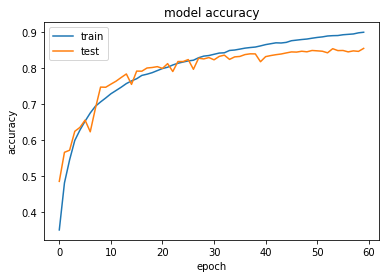

In [81]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(accuracy_img_name)

# Show figure
plt.show()

### Plot history for loss for training and testing process

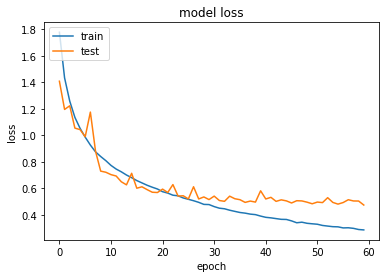

In [82]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')

# Save the figure
plt.savefig(loss_img_name)

# Show figure
plt.show()